# 昼夜图像分类器
---

昼夜图像数据集由200个RGB彩色图像组成，分为两类：白天图像和夜晚图像。每个例子都有相同的数字：100个日图像和100个夜图像。

我们希望建立一个分类器，可以把这些图像准确地标记为白天或黑夜。要完成这个任务，我们需要找出这两种图像之间的显著性特征！

*注：所有图像都来自 [AMOS 数据集](http://cs.uky.edu/~jacobs/datasets/amos/) （众多户外场景档案）。*


### 导入资源

在开始使用项目代码之前，请导入你需要的库和资源。

In [1]:
import cv2 # computer vision library
import helpers

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## 训练并测试数据
200张日/夜的图像被分成训练和测试数据集。

* 这些图像中的60％是训练图像，供你在创建分类器时使用。
* 另外40％是测试图像，将用于测试分类器的准确度。

首先，我们设置一些变量来跟踪图像的存储位置：

image_dir_training: 我们保存训练集的路径
image_dir_test: 我们保存测试集的路径


In [2]:
# Image data directories
image_dir_training = "day_night_images/training/"
image_dir_test = "day_night_images/test/"

## 加载数据集

前几行代码将加载训练日/夜图像，并将它们全部存储在变量`IMAGE_LIST`中。 该列表包含图像及其相关标签（“日”或“夜”）。

例如， `IMAGE_LIST` 中的第一个图像标签对可以通过索引访问：

In [3]:

# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(image_dir_training)


## 构建输入图像和输出标签的`STANDARDIZED_LIST` 函数 

该函数将输入一个图像标签对列表，并输出一个包含调整过的图像和数字标签的 **标准** 列表。

In [4]:
# Standardize all training images
STANDARDIZED_LIST = helpers.standardize(IMAGE_LIST)

## 将标准化数据可视化

显示一个来自STANDARDIZED_LIST的标准化图片。

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 1


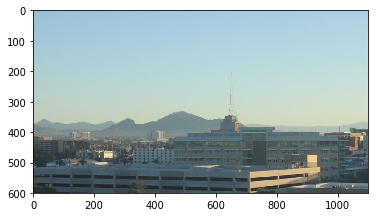

In [5]:
# Display a standardized image and its label

# Select an image by index
image_num = 0
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))




# 特征提取

创建一个表示图像亮度的特征。我们将使用HSV颜色空间提取**平均亮度**。具体来说，我们将使用V通道（亮度测量），将V通道中的像素值相加，然后将该总和除以图像的面积，从而获得该图像的平均值。

---
###  使用V通道查找平均亮度

该函数会输入 **标准化** 的RGB图像并返回一个代表图像亮度平均水平的特征（单个值）。我们将使用此值将图像分类为白天或夜晚。

In [6]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    area = 600*1100.0  # pixels
    
    # find the avg
    avg = sum_brightness/area
    
    return avg

Avg brightness: 35.217


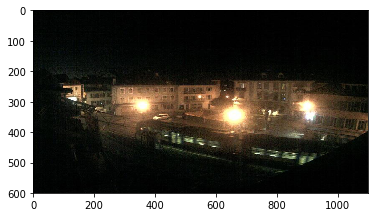

In [7]:
# Testing average brightness levels
# Look at a number of different day and night images and think about 
# what average brightness value separates the two types of images

# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 190
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)



# 分类和可视化误差

在本节中，我们将把我们的平均亮度特征转换为一个分类器，该分类器输入一个标准化图像并返回该图像的一个`predicted_label`。这个 `estimate_label` 函数应该返回一个值：0或1（分别代表夜晚或白天）。

---
###  建立一个完整的分类器 

以下代码，实现当给到某个RGB图像时，能返回预估的分类标签。

In [8]:
# This function should take in RGB image input
def estimate_label(rgb_image):
    
    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
        
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    threshold = 120
    if(avg > threshold):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the pred-cted_label can stay 0 (it is predicted to be "night")
    
    return predicted_label    
    

## 测试分类器

下面我们将要使用我们在notebook开始时放置的测试数据集，来测试你的分类算法！

由于我们使用了非常简单的亮度特征，因此可能不希望此分类器100％准确。我们的目标是使用这一函数，使准确度达到75-85％左右。


### 测试数据集

下面，我们加载测试数据集，使用上面定义的`standardize`函数对其进行标准化，然后对其进行**混洗**；这确保了顺序不会对测试准确度测试造成影响。

In [9]:
import random

# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = helpers.standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

## 确定准确度

将你的分类算法（也称为“模型”）的输出与真实标签进行比较并确定准确度。

此代码将所有错误分类的图像、其预测标签以及它们的真实标签存储在名为`misclassified`的列表中。

In [10]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


In [11]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.86875
Number of misclassified images = 21 out of 160


---
<a id='task9'></a>
### 将错误分类的图像可视化

将分类错误的一些图像（在`MISCLASSIFIED`列表中）可视化，并记下使其难以分类的所有特征。这样做可以帮助你发现分类算法的缺陷。

1


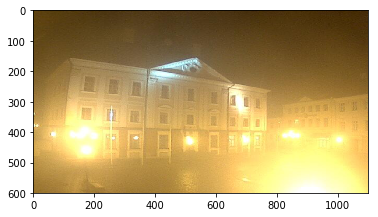

In [17]:
# Visualize misclassified example(s)
##  Display an image in the `MISCLASSIFIED` list 
##  Print out its predicted label - to see what the image *was* incorrectly classified as5
num = 0
test_mis_im = MISCLASSIFIED[num][0]
plt.imshow(test_mis_im)
print(str(MISCLASSIFIED[num][1]))